## Load data

In [1]:
import numpy as np

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
datapath = '/media/sf_VBox_Shared/timeseries/UCR_WaveGesture/'

In [4]:
X_train = np.load(datapath+'X_train.npy')
y_train_binary = np.load(datapath+'y_train_binary.npy')
X_val = np.load(datapath+'X_val.npy')
y_val_binary = np.load(datapath+'y_val_binary.npy')
X_test = np.load(datapath+'X_test.npy')
y_test_binary = np.load(datapath+'y_test_binary.npy')

print(X_train.shape)

(627, 315, 3)


In [5]:
num_classes = y_train_binary.shape[1]
print(num_classes)

8


## Generate models

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

Using Theano backend.


In [7]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen

In [8]:
models = modelgen.generate_models(X_train.shape, num_classes, number_of_models = 5, model_type = None)

In [9]:
for model, params, model_types in models:
    print(params)
    model.summary()

{'learning_rate': 0.019809313042832816, 'lstm_dims': array([69, 72, 33, 66]), 'filters': array([34, 27, 54])}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
reshape_1 (Reshape)                (None, 1, 315, 3)   0           reshape_input_1[0][0]            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)    (None, 34, 315, 3)  136         reshape_1[0][0]                  
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 34, 315, 3)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 27, 315, 3)  2781        activation_1[0]

## Compare models

In [10]:
# Only take small trainset
subsize_set = 100
X_train_sub = X_train[:subsize_set,:,:]
y_train_binary_sub = y_train_binary[:subsize_set,:]

In [11]:
nr_epochs = 5

histories = []
val_accuracies = []
val_losses = []
for model, params, model_types in models:
    history = model.fit(X_train_sub, y_train_binary_sub,
              nb_epoch=nr_epochs,batch_size=20, validation_data=(X_val, y_val_binary))
    histories.append(history)
    val_accuracies.append(history.history['val_acc'][-1])
    val_losses.append(history.history['val_loss'][-1])

Train on 100 samples, validate on 269 samples
Epoch 1/5
100/100 [==============================] - 8s - loss: 2.9249 - acc: 0.1200 - val_loss: 2.1859 - val_acc: 0.1152
Epoch 2/5
100/100 [==============================] - 9s - loss: 2.2764 - acc: 0.1700 - val_loss: 2.1195 - val_acc: 0.1413
Epoch 3/5
100/100 [==============================] - 9s - loss: 2.2659 - acc: 0.1500 - val_loss: 2.1163 - val_acc: 0.1338
Epoch 4/5
100/100 [==============================] - 10s - loss: 2.2346 - acc: 0.1100 - val_loss: 2.0903 - val_acc: 0.1152
Epoch 5/5
100/100 [==============================] - 10s - loss: 2.1624 - acc: 0.1300 - val_loss: 2.0839 - val_acc: 0.1413
Train on 100 samples, validate on 269 samples
Epoch 1/5
100/100 [==============================] - 0s - loss: 1.3623 - acc: 0.5400 - val_loss: 0.7516 - val_acc: 0.7509
Epoch 2/5
100/100 [==============================] - 0s - loss: 0.3657 - acc: 0.9200 - val_loss: 0.5265 - val_acc: 0.8476
Epoch 3/5
100/100 [==============================] -

In [12]:
def plotTrainingProcess(history, name='Model', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax2 = ax.twinx()
    LN = len(history.history['val_loss'])
    val_loss, = ax.plot(range(LN),history.history['val_loss'],'g--', label='validation loss')
    train_loss, = ax.plot(range(LN),history.history['loss'],'g-', label='train loss')
    val_acc, = ax2.plot(range(LN),history.history['val_acc'],'b--', label='validation accuracy')
    train_acc, = ax2.plot(range(LN),history.history['acc'],'b-', label='train accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss',color='g')
    ax2.set_ylabel('accuracy',color='b')
    plt.legend(handles=[val_loss, train_loss, val_acc, train_acc], loc=2, bbox_to_anchor=(1.1, 1))
    plt.title(name)

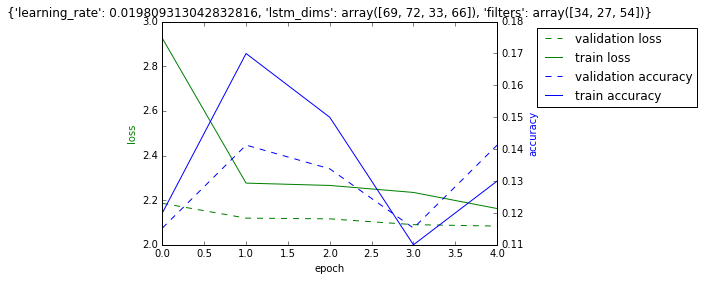

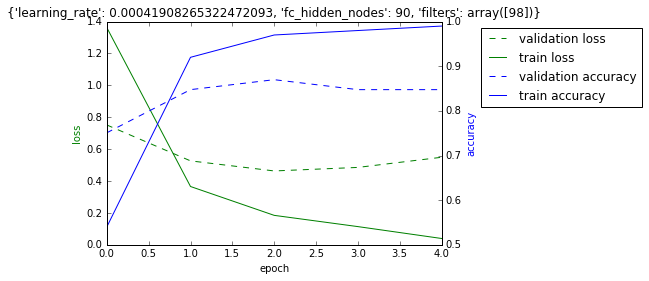

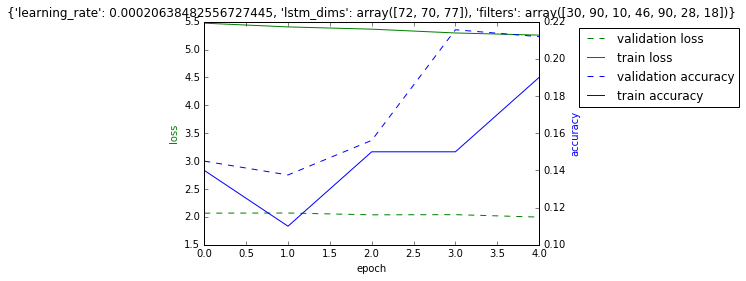

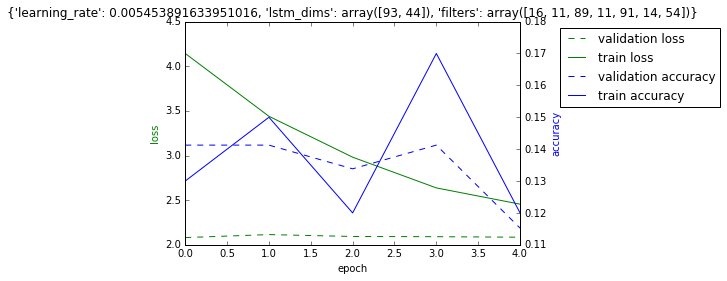

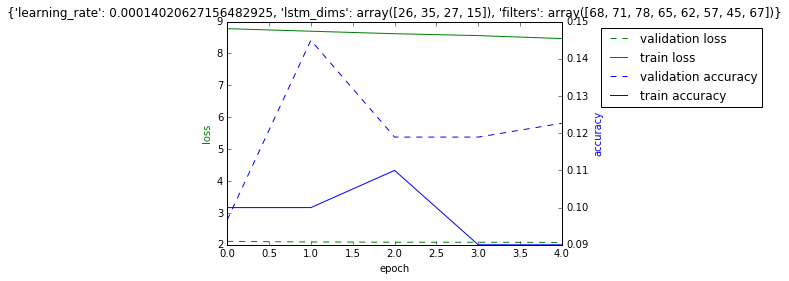

In [13]:
for i in range(len(models)):
    name = str(models[i][1])
    plotTrainingProcess(histories[i], name)

In [14]:
import pandas as pd

results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'learning_rate': 0.019809313042832816, 'lstm_...",0.13,2.162396,0.141264,2.083869
1,"{'learning_rate': 0.00041908265322472093, 'fc_...",0.99,0.039596,0.847584,0.549036
2,"{'learning_rate': 0.00020638482556727445, 'lst...",0.19,5.257565,0.211896,1.996629
3,"{'learning_rate': 0.005453891633951016, 'lstm_...",0.12,2.455202,0.115242,2.085109
4,"{'learning_rate': 0.00014020627156482925, 'lst...",0.09,8.468328,0.122677,2.074215


## Train the best model for real

In [15]:
best_model_index = np.argmax(val_accuracies)

In [20]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 CNN {'learning_rate': 0.00041908265322472093, 'fc_hidden_nodes': 90, 'filters': array([98])}


In [17]:
nr_epochs = 10

history = model.fit(X_train, y_train_binary,
              nb_epoch=nr_epochs,batch_size=20, validation_data=(X_val, y_val_binary))

Train on 627 samples, validate on 269 samples
Epoch 1/10
627/627 [==============================] - 42s - loss: 8.2298 - acc: 0.1324 - val_loss: 2.0683 - val_acc: 0.2082
Epoch 2/10
627/627 [==============================] - 36s - loss: 7.8188 - acc: 0.1483 - val_loss: 2.0657 - val_acc: 0.2119
Epoch 3/10
627/627 [==============================] - 35s - loss: 7.4273 - acc: 0.1547 - val_loss: 2.0501 - val_acc: 0.2416
Epoch 4/10
627/627 [==============================] - 41s - loss: 7.0488 - acc: 0.1707 - val_loss: 2.0019 - val_acc: 0.2230
Epoch 5/10
627/627 [==============================] - 36s - loss: 6.6482 - acc: 0.2568 - val_loss: 1.9328 - val_acc: 0.3160
Epoch 6/10
627/627 [==============================] - 38s - loss: 6.2567 - acc: 0.3190 - val_loss: 1.8358 - val_acc: 0.4126
Epoch 7/10
627/627 [==============================] - 38s - loss: 5.9139 - acc: 0.3604 - val_loss: 1.7514 - val_acc: 0.4944
Epoch 8/10
627/627 [==============================] - 52s - loss: 5.5700 - acc: 0.4306

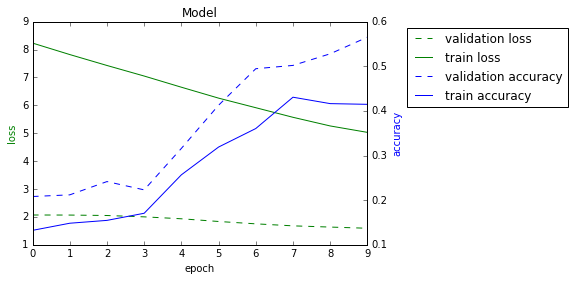

In [18]:
plotTrainingProcess(history)

## Test on Testset

In [19]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

Score of best model: [0.60555331461393658, 0.8308207703528625]
